### Implementation
* Move to Python3
* Git hub update
* Load Pierre protein list
* Check for exisiting path between any node and a seed node after edge trimming
* Remove network not connected with seed node 

### Study
$\Delta$ SimPct treshold

 * How many networks
 * Tabulate individual protein degree across the generated networks

| Protein| 80% | 60% | ... | 10% |
| ------ | --- | --- | --- | --- |
| XXX    | 22  | 10  | ... | NA  |



GO analysis:
* Global tablechart of GO terms occurences across the network
* For given Protein and its 1st neighbors, display the GO annotations distribution of the proteins and their templates

Note montage necessaire

    sshfs glaunay@arwen://mobi/group/divisome /Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen  -o umask=0002,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa
    
Example BLAST utilisé
```shell
gunzip -c ~/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/INTACT_VERSUS_R6R/BLAST_OUTPUT/P0/P0CI74/blast.out.gz | less
```

Gestion des IDs de Intact
Travail sur un subset (head 200)
> /home/lbarlet/WorkOnIntact/subset_intact.txt

split pour récup deux première colonnes 
ensuite trie pour savoir quelle ID est la plus présentes,
la seconde, ...

/!\ la deuxième ne doit pas présenter la première, etc /!\


TODO 

  1. Récuperer interaction experiemntals suplémentaires
  2. Alignement de séquences sur protéines du divisome
  3. Définition de blocs
  4. Métrique homologie basée sur la similarité dans ces blocs.



In [1]:
import sys
import os
import subprocess
sys.path.append('/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/omegaLoMo/lib')
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteinsExt/src")
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteins/src")

import omega
#%load_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import json
import networkx as nx
#%autoreload 2


import pandas
import json

def loadSeedList(lType='all'):
    rootDir='/Users/guillaumelaunay/work/projects/pneumocoque/lists'
    fileMap = {
        'phino' : 'DivAlreadyKnow_litt_phino.txt',
        'massida' : 'DivAlreadyKnow_litt_massida.txt',
        'barletMerge': 'divKnownR6.txt',
        'garcia' : 'pierre_uniprot_DL.tsv',
        'all' : 'current_merge.txt'
    }
    if lType not in fileMap:
        raise IndexError("no set named " + lType)
        
    pFrame = pandas.read_csv( rootDir + '/' + fileMap[lType], sep='\t', lineterminator='\n')
    return [ uniprotID for uniprotID in pFrame.loc[:]["Entry"] ]



* MITAB_file and filterIds can be filled when reading serialized data, or read from scratch, using input files.
* MITAB_file contains IntAct informations, restricted to physical interactions. 
It is a subset of the informations
from /mobi/group/divisome/physical_intact.mitab.txt, after serialization by an external python script.
* filterIds contains information about S pneumoniae
* intactR6filtered_topology is a dictionary, with pairs of UniProt Ids of proteins from IntAct interactions, that match with R6 sequences,
non redundant.

## Combining experimental evidences and homology relationship

### $I^{st}$ input *psicquic.MitabTopology* object

##### Previously pickled psicquic.MitabTopology object (see R6 topology notebook)

It can be viewed as a tree representation of an adjacency matrix
with non-zero cell elements storing list of mitab experimental evidences.

The actual data structure is a 2 level dictionnary of uniprotID keys referencing list of mitab informations


```json
{
    psicquicInteractorID : {
        psicquicInteractorID : [ psqDataObject , ...]
    }
    
}

```

API description

In [3]:
import pickle
#mitabTopologyPickle="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_safe.H50.mitabToplogy.pickle"
mitabTopologyPickle="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_safe.mitabToplogy.pickle"
mitabTopologyObject = None
with open(mitabTopologyPickle, 'rb') as fP:
    mitabTopologyObject = pickle.load(fP)
print("Number of interaction unpickled", len(mitabTopologyObject) )

Acknowledged 11221 entries (/Users/guillaumelaunay/work/data/pfam)
Number of interaction unpickled 54993


### $II^{nd}$ input *homology tree-like* document

Two level tree storing homology relationship between psicquic entries (**PSQ**) (primary keys) and
target proteome (**TP**) entries (secondary keys)
Leaves are array which contains one tuple per HSP (currently only one HSP)
HSP informations are

 **TP** sequence Length**,** **TP**_hsp start position**,** **TP**_hsp stop position**,** **PSQ**_sequence Length**,** **PSQ**_hsp start position**,** **PSQ**_hsp stop position**,** HSP positive match number**,** HSP identical match number**,** HSP eValue

```json
{
"P97760": {"P66709": [["311", "5", "235", "275", "5", "272", "95", "45", "4.79675e-27"]]},
"P98084": {"Q59947": [["1963", "262", "811", "750", "24", "572", "176", "95", "2.1715e-07"]], "Q8DQN5": [["1876", "191", "395", "750", "52", "281", "75", "47", "1.90067e-06"]]},
}
```


In [4]:
homologyFile="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_R6_homology.json"

## Building network Topology


##### **buildEdges ** 
Performs the homolog expansion

**args**:None

##### **resetEdges** 
Any network can be reverted to the state obtained at **buildEdge** completion

**args**:None
##### **trimEdges**
Discard homology relationship violating treshold-based constraints.
An edge without remaining homology relationship is removed

**args**: optional,named
 * idPct
 * simPct
 * cvPct
 
##### **nodes**
A dictionary attribute with network node and their supporting PSQ protein. 
```
{
    node_UniprotID : { PSQ_uniprotID, ... }
}
```



In [11]:
tag="uniprot_id40NTW"
om = omega.omegaTopology(mitabTopologyObject, homologyFile)
om.buildEdges()

84127  interactions unpacked from  54993


In [12]:
seedList=loadSeedList()
om.trimEdges(idPct=40.0)
G=om.prune(*seedList)

#nx.draw(G, with_labels = True)
jsonBean = om.dump()
#print(om.nodes)
#print(jsonBean)

83075  interactions removed from total


## Building supporting uniprot collection

In [13]:
import pyproteinsExt.uniprotAnnotator as uA
import pyproteinsExt.annotators as aT
from pyproteinsExt.uniprot import EntryEncoder
uColl = uA.getUniprotCollection()
uColl.setCache(location='/Users/guillaumelaunay/work/data/uniprot')
#uA.proxySetting(https="http://ftprox.ibcp.fr:3128", http="http://ftprox.ibcp.fr:3128")
from pyproteinsExt.uniprot import EntryEncoder

networkUP = {}
upDic = om.nodes
for n in upDic:
    l = [n] + list(upDic[n])
    for x in l:
        if x not in networkUP:
            networkUP[x] = uColl.get(x)

uniprotJsonString = json.dumps({"registry" : networkUP },  cls=EntryEncoder)

Changing cache location to /Users/guillaumelaunay/work/data/uniprot
Reindexing /Users/guillaumelaunay/work/data/uniprot
Acknowledged 11306 entries (/Users/guillaumelaunay/work/data/uniprot)


In [9]:
# write to FS if fetched were performed
uColl.serialize()

serializing uniprot collection
P07954 has non byte content
P0A4T1 has non byte content
P27448 has non byte content
O60673 has non byte content
P25539 has non byte content
Q02804 has non byte content
P00961 has non byte content
P63544 has non byte content
Q8DQ35 has non byte content
Q28021 has non byte content
P77257 has non byte content
P67050 has non byte content
Q8ZBZ9 has non byte content
Q8DMW1 has non byte content
O00622 has non byte content
O59757 has non byte content
Q8DQH5 has non byte content
P24182 has non byte content
Q14055 has non byte content
P13060 has non byte content
P62841 has non byte content
Q9ZKE7 has non byte content
O83265 has non byte content
P67087 has non byte content
O24970 has non byte content
Q8DQK9 has non byte content
P07001 has non byte content
P08865 has non byte content
P12829 has non byte content
Q81WF3 has non byte content
Q12815 has non byte content
P37465 has non byte content
O31602 has non byte content
Q9SRR0 has non byte content
P54115 has non by

In [14]:
with open("/Users/guillaumelaunay/tmp/buildNetwork2/" + tag + ".json", "w") as fp:
    #fp.write(uniprotJsonString)
    #fp.write("{\"network\":" + str (jsonBean).replace("\'", "\"") + ", " + uniprotJsonString[1:] )
    fp.write(str(jsonBean).replace("\'", "\"")[:-1] + ", " + uniprotJsonString[1:] )

## Building supporting mitab collection

In [15]:

#%autoreload 2
import pyproteins.container.Core as co
tColl = om.templateZipPair()
mitabTopologyObject.autoAppendable=True
mitabAsStr = ''
for t1, t2, d in tColl:
    mitabAsStr += str(mitabTopologyObject[t1][t2])

with open("/Users/guillaumelaunay/tmp/buildNetwork2/" + tag + ".mitab", "w") as fp:
    fp.write(mitabAsStr)

No seed to prune
('Q8DMY0', {'group': 0, 'val': 4})
('Q8DQM3', {'group': 0, 'val': 3})
('Q8DNW6', {'group': 0, 'val': 3})
('Q8DPN3', {'group': 0, 'val': 7})
('Q8DRI7', {'group': 0, 'val': 3})
('P0A2U9', {'group': 0, 'val': 4})
('Q8DQV2', {'group': 0, 'val': 2})
('Q8DN05', {'group': 0, 'val': 3})
('Q8CYB5', {'group': 0, 'val': 5})
('Q8DPF5', {'group': 0, 'val': 1})
('Q59947', {'group': 0, 'val': 13})
('Q8DQD4', {'group': 0, 'val': 1})
('Q8DQL1', {'group': 0, 'val': 1})
('Q8DP77', {'group': 0, 'val': 1})
('Q8DPK4', {'group': 0, 'val': 1})
('Q8DNJ8', {'group': 0, 'val': 1})
('Q8DNM1', {'group': 0, 'val': 1})
('Q8DP89', {'group': 0, 'val': 1})
('Q8DN72', {'group': 0, 'val': 1})
('Q8DNL4', {'group': 0, 'val': 1})
('Q8DP03', {'group': 0, 'val': 1})
('P0A4D8', {'group': 0, 'val': 3})
('Q8DPC2', {'group': 0, 'val': 1})
('Q8DRI0', {'group': 0, 'val': 4})
('P0A3R2', {'group': 0, 'val': 3})
('Q8CZC0', {'group': 0, 'val': 1})
('Q8DNS0', {'group': 0, 'val': 2})
('Q8DPM1', {'group': 0, 'val': 2})
('

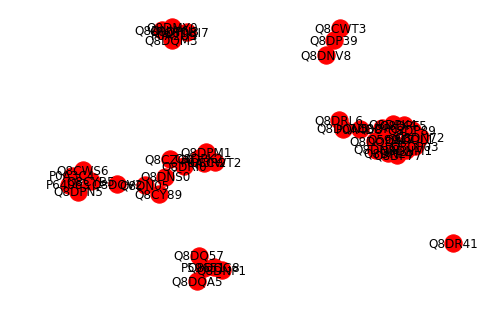

In [153]:
#G=om.prune('Q8DRI7')
G=om.prune()
for n in G.nodes(data=True):
    print (n)
nx.draw(G, with_labels=True)

3  interactions removed from total
{'nodes': [{'id': 'Q8DPJ9', 'group': 1, 'val': 10}, {'id': 'Q8DPN3', 'group': 0, 'val': 8}, {'id': 'Q8DQM3', 'group': 0, 'val': 4}, {'id': 'Q8DNS0', 'group': 0, 'val': 3}, {'id': 'Q8DMY0', 'group': 0, 'val': 5}, {'id': 'Q8DNW6', 'group': 0, 'val': 4}, {'id': 'Q8DRI7', 'group': 0, 'val': 4}, {'id': 'P0A2U9', 'group': 0, 'val': 5}, {'id': 'Q8DRI0', 'group': 0, 'val': 3}, {'id': 'Q8CZC0', 'group': 0, 'val': 2}, {'id': 'Q8DPK2', 'group': 0, 'val': 2}, {'id': 'Q8DPM1', 'group': 0, 'val': 1}, {'id': 'Q8CY89', 'group': 0, 'val': 1}, {'id': 'Q8DN05', 'group': 0, 'val': 2}], 'links': [{'source': 'Q8DPJ9', 'target': 'Q8DPJ9', 'data': {'lowQueryParam': [['O13710', '1179', '1', '1171', '1076', '22', '1058', '342', '128', '8.14002e-31']], 'highQueryParam': [['P53692', '1179', '1', '1170', '1140', '95', '1135', '354', '162', '1.92613e-33']]}}, {'source': 'Q8DPJ9', 'target': 'Q8DPN3', 'data': {'lowQueryParam': [['P53692', '1179', '1', '1170', '1140', '95', '1135', '

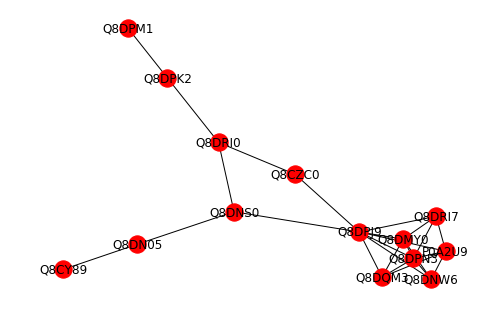

In [167]:
#G = iObj.graph(seedNodes=seedList[:], idPct=20.0)
seedList=['Q8DPJ9']
om.trimEdges(idPct=10.0)
G=om.prune(*seedList)

nx.draw(G, with_labels = True)
jsonBean = om.dump()
print(om.nodes)



In [166]:
om.dump()

{'links': [{'data': {'lowQueryParam': [['O13710', '1179', '1', '1171', '1076', '22', '1058', '342', '128', '8.14002e-31']], 'highQueryParam': [['P53692', '1179', '1', '1170', '1140', '95', '1135', '354', '162', '1.92613e-33']]},
   'source': 'Q8DPJ9',
   'target': 'Q8DPJ9'},
  {'data': {'lowQueryParam': [['P53692', '1179', '1', '1170', '1140', '95', '1135', '354', '162', '1.92613e-33'], ['O13710', '1179', '1', '1171', '1076', '22', '1058', '342', '128', '8.14002e-31']], 'highQueryParam': [['O13710', '555', '2', '395', '1076', '24', '417', '132', '48', '4.49776e-05'], ['P53692', '555', '41', '521', '1140', '652', '1138', '124', '51', '7.82274e-05']]},
   'source': 'Q8DPJ9',
   'target': 'Q8DPN3'},
  {'data': {'lowQueryParam': [['O13710', '1179', '1', '1171', '1076', '22', '1058', '342', '128', '8.14002e-31']], 'highQueryParam': [['P53692', '213', '130', '208', '1140', '1038', '1122', '31', '16', '5.37396e-05']]},
   'source': 'Q8DPJ9',
   'target': 'Q8DQM3'},
  {'data': {'lowQueryParam'

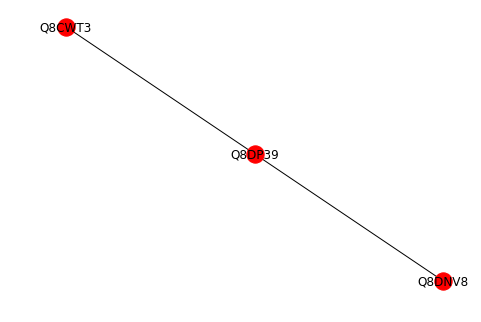

In [72]:
G=om.prune('Q8DNV8')
nx.draw(G, with_labels = True)

In [89]:
for node1, node2, data in G.edges(data=True):
    print(data)

{'data': {'lowQueryParam': [['O13710', '1179', '1', '1171', '1076', '22', '1058', '342', '128', '8.14002e-31'], ['Q53EZ4', '1179', '676', '977', '464', '117', '426', '106', '38', '0.0133861']], 'highQueryParam': [['P53692', '1179', '1', '1170', '1140', '95', '1135', '354', '162', '1.92613e-33'], ['P55081', '1179', '673', '968', '439', '47', '342', '87', '27', '0.0261497']]}}
{'data': {'lowQueryParam': [['P53692', '1179', '1', '1170', '1140', '95', '1135', '354', '162', '1.92613e-33'], ['O13710', '1179', '1', '1171', '1076', '22', '1058', '342', '128', '8.14002e-31']], 'highQueryParam': [['O13710', '555', '2', '395', '1076', '24', '417', '132', '48', '4.49776e-05'], ['P53692', '555', '41', '521', '1140', '652', '1138', '124', '51', '7.82274e-05']]}}
{'data': {'lowQueryParam': [['O13710', '1179', '1', '1171', '1076', '22', '1058', '342', '128', '8.14002e-31']], 'highQueryParam': [['P53692', '213', '130', '208', '1140', '1038', '1122', '31', '16', '5.37396e-05']]}}
{'data': {'lowQueryPara

In [34]:
seedList = loadSeedList()
#seedList=['Q8DNV9']a
G = iObj.graph(seedNodes=seedList[:], idPct=30.0)
graph.NodeView(G)

['P32501', '330', '436', '42', '22', '2.79369e-10']  --  ['P20459', '193', '364', '71', '31', '8.30407e-31']


IndexError: list index out of range

###### SCRATCH ABOVE

In [34]:
from hashlib import md5
s1="Q8DP75"
s2="P0A2U9"
if md5(s1.encode("utf-8")).hexdigest() >  md5(s2.encode("utf-8")).hexdigest():
    print(s1, " > ", s2)

Q8DP75  >  P0A2U9


In [36]:
hCheck.data["P30750"]

[['Q8DRF9', '5', '352', '231', '155', '1.43726e-98'],
 ['Q8DQD4', '5', '244', '155', '94', '3.69627e-92'],
 ['Q8DPF5', '5', '379', '165', '92', '5.65842e-91'],
 ['Q8DPC2', '5', '245', '137', '79', '3.66768e-90'],
 ['Q8DNM1', '1', '239', '133', '81', '1.09418e-89'],
 ['Q8DP03', '1', '249', '130', '77', '3.49061e-88'],
 ['Q8DPK4', '6', '246', '150', '92', '4.91583e-87'],
 ['Q8DNI2', '20', '290', '141', '81', '3.10758e-86'],
 ['Q8DP77', '1', '241', '144', '95', '6.21133e-86'],
 ['Q8DNJ8', '1', '241', '135', '78', '2.60962e-84'],
 ['Q8DQL1', '5', '240', '143', '91', '4.96133e-84'],
 ['Q8DRC8', '4', '247', '131', '73', '3.89617e-83'],
 ['P0A2U9', '8', '296', '139', '87', '6.37616e-82'],
 ['Q8DQF8', '4', '221', '129', '90', '9.75809e-82'],
 ['Q8DMX9', '4', '230', '134', '84', '4.35264e-75'],
 ['Q8DQH4', '3', '225', '137', '88', '4.39038e-74'],
 ['Q8DR01', '5', '245', '143', '84', '5.14609e-73']]

In [5]:
%autoreload 2




#### Deprecated


# Creating an IntAct topolgy dictionary from scratch
# all physical interactions from IntAct: 348,806 interactions 
MITAB_file="/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/physical_intact.mitab.txt"
# a subset of 20,000 interactions 
MITAB_file="/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/physical_intact.mitab_20000.txt"
filterIds="/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/anaBlast/allInR6Test2"

# same, but sourcing from the directory generated by JM
#MITAB_file="/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/INTACT_VERSUS_R6R/physical_intact.mitab_20000.txt"
MITAB_file="/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/INTACT_VERSUS_R6R/physical_intact.mitab.txt"
# So far, we only parse the IntAct ids, not the R6 info
filterIds="/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/POST_PROCESS_INTACT_VERSUS_R6R/allHitsInR6.txt"
# 

# create Topolgy object
topo = cT.Topology()
# this step, with the complete MITAB_file physical_intact.mitab.txt, takes
# about 40 minutes 
# parse MITAB file
#topo.parseIntactMitab(MITAB_file)
# filter the IntAct interactions, to remove protein Ids with no match with R6
#topo.filterWith(filterIds)

# Create an IntAct topology from object deserialisation
topo.deSerialize('/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/serializedData/newDic.json')

intactR6filtered_topology=topo.newDic
#print intactR6filtered_topology

# OK 

## File format of allInR6.json files

** File content: **

```json
{
"Q6A162" : [ [ "Q8DRI0",  "74", "316",  "76", "31", "1.63488e-07" ],
             [ "Q8DPJ9", "233", "491", "101", "47", "8.67392e-07" ],
             [ "Q8DN05", "124", "460", "108", "32", "0.0420328" ]
            ],
 ...
 }
```

** Explanation **

Means that the IntAct UniprotId Q6A162 has 3 hits in the R6 proteome: Q8DRI0, Q8DPJ9, and Q8DN05. 
    Arrays informations beyond the first position
    are the alignment statistics : Hsp_hit-from, Hsp_hit-to, Hsp_positive, Hsp_identity, Hsp_evalue
    /mobi/group/divisome/UsineBlastArrayIntact_vs_R6/IntactVsR6/swork/Q6/Q6A162/logs

** Native BLAST results **

** Generation of BLAST results **



## Omega Set creation
The omegaSet object stores query organism homologs vector for each protein found in PSICQUIC

#### From scratch, omegaSet object construction
  + From Loic's files 
    ```python
    indexR6 = '/Volumes/arwen/mobi/group/divisome/serializedData/indexR6'
    blastResults='/Volumes/arwen/mobi/group/divisome/UsineBlastArrayIntact_vs_R6/IntactVsR6/swork/'
    ```
  + From Juliettes rebuildt files 
    ```python
    indexR6 = '/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/POST_PROCESS_INTACT_VERSUS_R6R/R6_index.txt'
    blastResults='/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/POST_PROCESS_INTACT_VERSUS_R6R/OUTPUT/'
    ```
  
  + Calling constructor on XML **OR** JSON ressources
  ```python
  omegaSet=ca.HomegaSet(queryIdList=indexR6,blastXmlPath=blastResults)
  omegaSet=ca.HomegaSet(queryIdList=indexR6,jsonSerialPath=blastResults)
  ```

#### Deserializing a previous instance of _omegaSet_
  + Calling constructor on serial JSON ressource   
    ```python
    omegaSet=ca.HomegaSet(queryIdList=indexR6,bean="/Users/guillaumelaunay/grosTas.json")
    ```
  
#### Serializing current instance of _omegaSet_
 + Calling method with path to file for writing   
    ```python
    omegaSet.serialize("/Users/guillaumelaunay/grosTas.json")
    ```
    

In [7]:
indexR6 = '/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/POST_PROCESS_INTACT_VERSUS_R6R/R6_index.txt'
blastResults='/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/POST_PROCESS_INTACT_VERSUS_R6R/OUTPUT/'
omegaSet=ca.HomegaSet(queryIdList=indexR6, bean="/Users/guillaumelaunay/grosTas.json")



<span style="color:brown;font-weight:bold"> GL -- Needs documentation reformat </span>

## Omega Set description

OmegaSet is a list of omegaVectors objects.
    
** Description of the omegaVector object **

* a dictionary with a key "template ID", value= a UniprotId from IntAct,
    * a key "Pairs Data", value= list of dictionnaries 
        * "query" : R6 Ids
        * "param" : list of HSP statistics
        * "template" : the template Id (identical to template ID)
            
** FullOmegaSet_coverage.json **
a serialized file with all HSP statistics, for all IntAct proteins.
Hence, we need to use the argument queryIdList=indexR6, to filter out HSPs that do not belong to R6.
    
** Generation of indexR6 and FullOmegaSet_coverage.json **
* indexR6: a simple list of Uniprot Ids from the R6 proteome
    
    ```bash
    head  /Volumes/arwen/mobi/group/divisome/serializedData/indexR6
    ```
    
````
sp|P0A2U7|ADCC|STRR6.seq
sp|P0A2U9|AMIE|STRR6.seq
sp|P0A2V9|PSTB3|STRR6.seq
sp|P0A2W1|ACP|STRR6.seq
sp|P0A2W7|ACPS|STRR6.seq
sp|P0A2W9|ALR|STRR6.seq
sp|P0A2X4|EXOA|STRR6.seq
sp|P0A2Y3|ARGR|STRR6.seq
sp|P0A2Y7|AROC|STRR6.seq
sp|P0A2Y9|ATP6|STRR6.seq
```
* FullOmegaSet_coverage.json   



## From omega Set to interactome

#### 1. Connect omegaVector objects
```python
omegaMatrix = ca.OmegaMatrix(topo = intactR6filtered_topology, omegaSet = omegaSet)
omegaMatrix.reduceAndVectorInject()
```
#### 2. Build the adjacency matrix in R6
```python
queryTopo = omegaMatrix.project()
```

##### Remarks
list of predicted interactions in R6. Each R6 interaction (= pair of nodes) is associated with 1 (or more) IntAct pairs, and their homology relationships are characterized by HSP statistics, ofc one predicted pair can be supported by several IntAct pairs


### Homology information support description
<figure>
<img src="binary.jpg", width="250px">
<figcaption>
Any interaction is binary, one node is arbitrarly defined as the "loQuery" (uniprotID: P60414) and the other as the "hiQuery" (uniprotID: Q8DPU0).
</figcaption>
</figure>



##### edgeAttributes tuple
It is a 3 elements tuple structured as :

```python
(Q8DR57, #Node uniprot Identifier on the "lowQuery" side of the edge
 Q9EUQ7, #Node uniprot Identifier on the "highQuery" side of the edge
 {'lowQueryParam': [
     # Each homolog relationship supporting interaction inference on the "low" side of the edge
     [u'1', u'105', u'66', u'49', u'3.02566e-17', u'98', u'3', u'98', u'109', 'P0CI74']
     ],
  'highQueryParam': [
      # Each homolog relationship supporting interaction inference on the "high" side of the edge
      [u'3', u'230', u'138', u'84', u'7.50339e-38', u'251', u'6', u'242', u'242', 'P35154']
      ]
})
```
##### Content of the Interaction inference Parameters Array

<span style="color:red;font-weight:bold">NB:</span>
*When refering to the blast output file hit and query are reversed, ie: query sequences come from PSICQUIC and target/template from R6*. <span style="color:red">LoMo messed it up, hence the cluncky following ordering of **query/template** sequence lengths.

In the following document **Query** refers to bacterial proteome element and **Template** to PSICQUIC element.

<ul style="list-style-type: none;">
  <li><span style='color:steelblue;font-weight:bold'>[1]</span>  Hsp position start in **query** sequence</li>
  <li><span style='color:steelblue;font-weight:bold'>[2]</span>  Hsp position stop in **query** sequence</li>
  <li><span style='color:steelblue;font-weight:bold'>[3]</span>  Hsp alignemnt positive match</li>
  <li><span style='color:steelblue;font-weight:bold'>[4]</span>  Hsp alignemnt identical match</li>
  <li><span style='color:steelblue;font-weight:bold'>[5]</span>  Hsp alignment eValue</li>
  <li><span style='color:steelblue;font-weight:bold'>[6]</span>  **Template** sequence total length</li>
  <li><span style='color:steelblue;font-weight:bold'>[7]</span>  Hsp position start in **template** sequence</li>
  <li><span style='color:steelblue;font-weight:bold'>[8]</span>  Hsp position stop in **template** sequence</li>
  <li><span style='color:steelblue;font-weight:bold'>[9]</span>  **Query** sequence length</li>
  <li><span style='color:steelblue;font-weight:bold'>[10]</span> **Template** uniprot identifier</li>
  
</ul>


eg:

The following XML blast output (`P0CI74/blast.out.gz`) will produce previous egde homology support

```xml
 <BlastOutput_query-len>98</BlastOutput_query-len>
 ... [LAST PSI-BLAST ITERATION]
 <Hit>
          <Hit_num>4</Hit_num>
          <Hit_id>sp|Q8DR57|GPSB_STRR6</Hit_id>
          <Hit_def>Cell cycle protein GpsB OS=Streptococcus pneumoniae (strain ATCC BAA-255 / R6) GN=gpsB PE=3 SV=2</Hit_def>
          <Hit_accession>Q8DR57</Hit_accession>
          <Hit_len>109</Hit_len>
          <Hit_hsps>
            <Hsp>
              <Hsp_num>1</Hsp_num>
              <Hsp_bit-score>87.5355</Hsp_bit-score>
              <Hsp_score>216</Hsp_score>
              <Hsp_evalue>3.02566e-17</Hsp_evalue>
              <Hsp_query-from>3</Hsp_query-from>
              <Hsp_query-to>98</Hsp_query-to>
              <Hsp_hit-from>1</Hsp_hit-from>
              <Hsp_hit-to>105</Hsp_hit-to>
              <Hsp_query-frame>1</Hsp_query-frame>
              <Hsp_hit-frame>1</Hsp_hit-frame>
              <Hsp_identity>49</Hsp_identity>
              <Hsp_positive>66</Hsp_positive>
              <Hsp_gaps>9</Hsp_gaps>
              <Hsp_align-len>105</Hsp_align-len>
              <Hsp_qseq>ADKVKLSAKEILEKEFKTGVRGYKQEDVDKFLDMIIKDYETFHQEIEELQQENLQLKKQLEEASKKQPVQ---------SNTTNFDILKRLSNLEKHVFGSKLYD</Hsp_qseq>
              <Hsp_hseq>MASIIFSAKDIFEQEFGREVRGYNKVEVDEFLDDVIKDYETYAALVKSLRQEIADLKEELTRKPKPSPVQAEPLEAAITSSMTNFDILKRLNRLEKEVFGKQILD</Hsp_hseq>
              <Hsp_midline>   +  SAK+I E+EF   VRGY + +VD+FLD +IKDYET+   ++ L+QE   LK++L    K  PVQ         S+ TNFDILKRL+ LEK VFG ++ D</Hsp_midline>
            </Hsp>
          </Hit_hsps>
        </Hit>
```

In [8]:
omegaMatrix = ca.OmegaMatrix(topo = intactR6filtered_topology, omegaSet = omegaSet)
omegaMatrix.reduceAndVectorInject()
queryTopo = omegaMatrix.project()

## Graphs Functions

Utility functions to 
  + Load specific seed datasets
    ```python
    seedList = loadSeedList('all' OR 'phino' OR 'massida')
    ```
  + dump network topology under json format compliant with [Dforce,D3--style](https://bl.ocks.org/vasturiano/02affe306ce445e423f992faeea13521)
   ```python
    networkAsD3_dict = nEncode(G)
    with open('interactome.json', 'w') as outfile:
        json.dump(networkAsD3_dict, outfile)
    ```

In [22]:


def nEncode(G):
    data = { 'nodes' : [], 'links' : [] }
    
    for e in G.edges(data=True):
        data['links'].append({ 'source' : str(e[0]), 'target' : str(e[1]), 'value' : len(e[2]['lowQueryParam']),
                             'data' : e[2] })

    for n in G.nodes(data=True):
        data['nodes'].append({'id' : str(n[0]), 'group' : n[1]['group'], 'val' : G.degree(n[0]) })
    return data

In [10]:
import graph as graph
iObj2 = graph.Interactome(queryTopo)


In [11]:
seedList = loadSeedList()
#seedList=['Q8DNV9']a
G = iObj2.graph(seedNodes=seedList[:], idPct=30.0)
graph.NodeView(G)

Total number of pruned edges is 86993 / 90266
Deleting 36 nodes unconnected to seed


Q8DQ84,74
P0A336,66
Q8DNA3,62
Q8DQD4,57
Q8DPC2,54
Q8DPK4,51
P65240,50
P65242,50
Q8CZE9,50
P64063,50
Q8DPS0,47


## Node template assignment robustness to similarity treshold

* Defines a range of Pct Similiarity treshold values to prune network
* Foreach treshold store Node degrees `[{'nodeRef': Q8DQD4, 'degree': 96}, ...]`

#### Utility functions
* doSnaphots
* writeSnapshots

In [9]:
def doSnapshots(G, _min=30, _max=100, step=20):
    gallery = {}
    for t in range(_min, _max, step):
        print("Minimal pct similarity", t)
        G = iObj2.graph( seedNodes=seedList[:], simPct=float(t) )
        gallery[t] = snapShotDegree(G)
    
    return gallery

def writeSnapshots(gallery, fileOut="/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/omegaLoMo/gallery.json"):
    asStr = {}
    for t in gallery:
        asStr[t] = []
        for e in gallery[t]:
            asStr[t].append( { str(k) : str(e[k]) for k in e } )

    with open(fileOut, "w") as f:
        json.dump(asStr, f)
    print ("All snapshots written at", fileOut)

def snapShotDegree(G):
    d = nx.degree(G)
    return sorted( [ { 'nodeRef' : k[0], 'degree' : k[1] } for k in d ], key=lambda x: x['degree'], reverse=True)



Minimal pct similarity 30
Total number of pruned edges is 18252 / 90266
Deleting 1 nodes unconnected to seed
Minimal pct similarity 50
Total number of pruned edges is 86328 / 90266
Deleting 31 nodes unconnected to seed
Minimal pct similarity 70
Total number of pruned edges is 90065 / 90266
Deleting 101 nodes unconnected to seed
Minimal pct similarity 90
Total number of pruned edges is 90141 / 90266
Deleting 42 nodes unconnected to seed


In [43]:
print(gallery[30][:1],gallery[50][:1])

[{'nodeRef': Q8DPJ9, 'degree': 820}] [{'nodeRef': Q8DQD4, 'degree': 96}]


### Horizontal bar chart representation of the degrees of the most connected node at each treshold stage
 * Sort Node per decreasing connectivity
   - Take the 20 first id's at SimPct 50
   
 * Make a BarChart

[Text(0,0,'Q8DPJ9'),
 Text(0,0,'Q8DNS0'),
 Text(0,0,'Q8DRI0'),
 Text(0,0,'P67283'),
 Text(0,0,'Q8DQV2'),
 Text(0,0,'Q8DN05'),
 Text(0,0,'Q8DQN5'),
 Text(0,0,'Q8DNP9'),
 Text(0,0,'Q8DRL6'),
 Text(0,0,'Q8CYG6'),
 Text(0,0,'Q8DQD4'),
 Text(0,0,'Q8DPC2'),
 Text(0,0,'Q8DPK4'),
 Text(0,0,'P0A336'),
 Text(0,0,'Q8DMX2'),
 Text(0,0,'Q8DQ84'),
 Text(0,0,'Q8DR73'),
 Text(0,0,'Q8DNA3'),
 Text(0,0,'P63788'),
 Text(0,0,'P64063'),
 Text(0,0,'P59661'),
 Text(0,0,'Q8CWN9'),
 Text(0,0,'Q8DRB3'),
 Text(0,0,'Q8DPS0'),
 Text(0,0,'Q8CWT2'),
 Text(0,0,'Q8DQL6'),
 Text(0,0,'Q8CWT4'),
 Text(0,0,'P63589'),
 Text(0,0,'P65947'),
 Text(0,0,'Q8DNI9'),
 Text(0,0,'P59661'),
 Text(0,0,'Q8CWN9'),
 Text(0,0,'Q8DRB3'),
 Text(0,0,'Q8DPS0'),
 Text(0,0,'Q8CWT2'),
 Text(0,0,'Q8DQL6'),
 Text(0,0,'Q8CWT4'),
 Text(0,0,'P63589'),
 Text(0,0,'P65947'),
 Text(0,0,'Q8DNI9')]

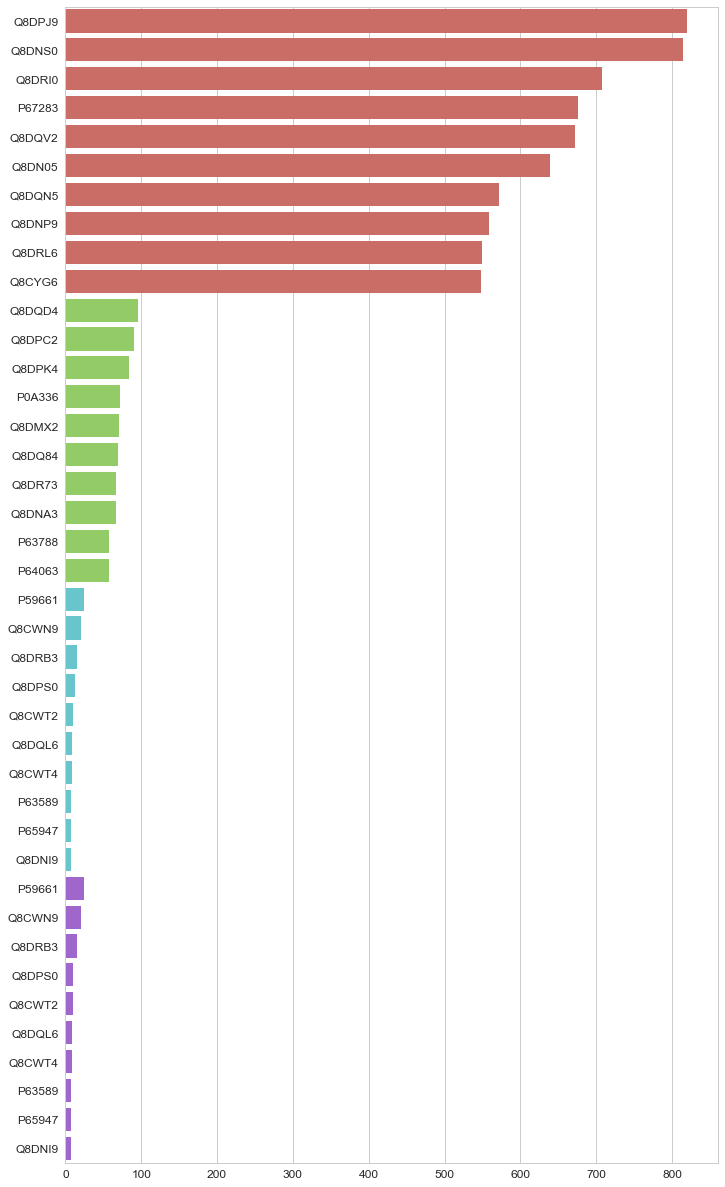

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

nFirst = 10
nThresh = 4

# Extract n first in each increasing threshold conditions
data_flat = []
_sim = list(gallery.keys())
_sim.sort()

for t in _sim:
    data_flat += gallery[t][:(nFirst)]

# Pick One color foreach treshold condition
# Inital set of even-spaced color
palette = sns.color_palette("hls", nThresh)

y_dummies = [ i + i%nThresh for i in range(0, len(data_flat) ) ]
y_dummies = [ i for i in range(0, len(data_flat) ) ]
x_degree  = [ d["degree"] for d in data_flat ]
y_labels  = [ d["nodeRef"] for d in data_flat ]

colors = []
c  = -1
_C = []
for i,e in enumerate(data_flat):
    if i%nFirst == 0:       
        c += 1
    colors.append(palette[c])
    _C.append(c)

sns.set(style="whitegrid", font_scale = 1.2)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 21.27)
sns.set_color_codes("pastel")
sns.barplot(x=x_degree, y=y_dummies, orient='h', ax = ax, label="Total", palette=colors, ci=None)
ax.set_yticklabels(y_labels)

### Interactome enrichment and serialization

* Loading uniprot ressources
* Statistics on GO term occurences

In [12]:
%autoreload 2

# Development library
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteinsExt/src")
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteins/src")

import pyproteinsExt.uniprotAnnotator as uA
import pyproteinsExt.annotators as aT
from pyproteinsExt.uniprot import EntryEncoder
uColl = uA.getUniprotCollection()
uColl.setCache(location='/Users/guillaumelaunay/work/data/uniprot')
uA.proxySetting(https="http://ftprox.ibcp.fr:3128", http="http://ftprox.ibcp.fr:3128")

Acknowledged 2176 entries (/Users/guillaumelaunay/work/data/pfam)
Acknowledged 0 entries (/Users/guillaumelaunay)
Changing cache location to /Users/guillaumelaunay/work/data/uniprot
Reindexing /Users/guillaumelaunay/work/data/uniprot
Acknowledged 2275 entries (/Users/guillaumelaunay/work/data/uniprot)
!!Proxy set to {'https': 'http://ftprox.ibcp.fr:3128', 'http': 'http://ftprox.ibcp.fr:3128'}


##### Remark & example
A specific Uniprot object JSON serializer was developed for the task of writing a interactome.json file w/ uniprot data

In [54]:
import json
uObj = uColl.get('Q8DR57')
json.dumps(uObj, cls=EntryEncoder)

Acknowledged 2176 entries (/Users/guillaumelaunay/work/data/pfam)


'{"a": {"name": "GPSB_STRR6", "GO": [{"id": "GO:0005737", "term": "C:cytoplasm", "evidence": "ECO:0000501"}, {"id": "GO:0007049", "term": "P:cell cycle", "evidence": "ECO:0000501"}, {"id": "GO:0051301", "term": "P:cell division", "evidence": "ECO:0000501"}, {"id": "GO:0008360", "term": "P:regulation of cell shape", "evidence": "ECO:0000501"}]}}'

### Go Term analysis TO REWORK

 * Enriching a network in uniprot object
 * Returns a GO terms chart

In [11]:
class GoDict(object):
    
    def __init__(self):
        self.data = {}

    def addUniprotObj(self, uniprotObj):
        for g in uniprotObj.GO:
            if str(g) not in self.data:
                self.data[str(g)] = 0
            self.data[str(g)] += 1
            
    def sort(self):
        GoScore = [ (d, self.data[d]) for d in self.data ]
        GoScore.sort(key=lambda x:x[1], reverse=True)
        return GoScore


class GoScoreObj(object):
    def __init__(self, data):
        self.data = data
    def _repr_html_(self):
        htmlString = '<table><thead><th>GO term</th><th>Occurence</th></thead><tbody>'
        for t in self.data:
            htmlString += '<tr><td>' + str(t[0]) + '</td><td>' + str(t[1]) + '</td></tr>'

        htmlString += '</tbody></table>'

        return htmlString

def uniprotObjListGoScore(uniprotObjList):
    goDict = GoDict()
    for uniprotObj in uniprotObjList:
        goDict.addUniprotObj(uniprotObj)
        
    return goDict.sort()
    
def GOchartGraph(G):
    for n in G.nodes():
        if 'uniprot' in G.node[n]:
            continue
        G.node[n]['uniprot'] = uColl.get(str(n))
        
    uniprotObjList = [ G.node[n]["uniprot"] for n in G.nodes() if G.node[n]["uniprot"] ]
    return GoScoreObj( uniprotObjListGoScore(uniprotObjList) )
   
def GOneighbouring(G, nodeName, radius=1):
    _g = nx.ego_graph(G, nodeName, radius)
    uniProtRefQuery = {}
    uniProtRefTemplate = {}
    
    for e in _g.edges():
        if str(e[0]) not in uniProtRefQuery:
            uniProtRefQuery[ str(e[0]) ] = 'query' 
        if str(e[1]) not in uniProtRefQuery:
            uniProtRefQuery[ str(e[1]) ] = 'query'  
        
        edgeDatum = G.get_edge_data(*e)       
        for _param in edgeDatum['lowQueryParam'] + edgeDatum['highQueryParam']:
            if _param[9] not in uniProtRefTemplate:
                uniProtRefTemplate[ _param[9] ] = 'template'
            
    print (len(uniProtRefTemplate.keys()), ' Templates and ',len(uniProtRefQuery.keys()), ' Queries uniprot entities to create')
    uniprotObjListQ = [ uColl.get(k) for k in uniProtRefQuery ]
    uniprotObjListQ = [ e for e in uniprotObjListQ if e ]
    goScoreQ = GoScoreObj( uniprotObjListGoScore(uniprotObjListQ) )
    
    uniprotObjListT = [ uColl.get(k) for k in uniProtRefTemplate ]
    uniprotObjListT = [ e for e in uniprotObjListT if e ]
    goScoreT = GoScoreObj( uniprotObjListGoScore(uniprotObjListT) )
    return (goScoreQ, goScoreT)

In [109]:
(goScoreQ, goScoreT) = GOneighbouring(G, "P0A2W7")

6  Templates and  6  Queries uniprot entities to create
got to fetch Q8CWN9
got to fetch Q8CWN9
got to fetch P59661
got to fetch P59661
got to fetch Q8CWT4
got to fetch Q8CWT4
got to fetch Q8CWT2
got to fetch Q8CWT2
got to fetch Q8DRB3
got to fetch Q8DRB3
got to fetch Q97NV3
got to fetch Q97NV3
got to fetch P0A2W6
got to fetch P0A2W6
got to fetch Q97SE5
got to fetch Q97SE5
got to fetch Q97S73
got to fetch Q97S73
got to fetch P95830
got to fetch P95830
got to fetch Q97SR4
got to fetch Q97SR4


##### Dumping network and auxilliary uniprot data in the same `interactome.json` file

In [51]:
networkEnriched = nEncode(G)
networkEnriched['registry'] = uniprotRegistry
fOut = "/Users/guillaumelaunay/work/projects/pneumocoque/3Dnetwork/3D_force/networks/interactome_40id_enriched.json"
with open(fOut, 'w') as outfile:
    json.dump(networkEnriched, outfile, cls=EntryEncoder)




In [72]:
goScoreT

GO:0005737:C:cytoplasm{ECO:0000501},1
GO:0005524:F:ATP binding{ECO:0000501},1
GO:0042802:F:identical protein binding{ECO:0000314},1
GO:0004595:F:pantetheine-phosphate adenylyltransferase activity{ECO:0000314},1
GO:0015937:P:coenzyme A biosynthetic process{ECO:0000314},1
GO:0005829:C:cytosol{ECO:0000314},1
GO:0022625:C:cytosolic large ribosomal subunit{ECO:0000314},1
GO:0015934:C:large ribosomal subunit{ECO:0000315},1
GO:0042788:C:polysomal ribosome{ECO:0000315},1
GO:0032993:C:protein-DNA complex{ECO:0000315},1
"GO:0001217:F:bacterial-type RNA polymerase transcriptional repressor activity, sequence-specific DNA binding{ECO:0000315}",1


In [ ]:
def GoPick(G, nodeName):    
    nx.ego_graph(G, nodeName, radius)
    # list Each node template
    # Try to fetch GO term
    

In [37]:
GOchart(G)

got to fetch Q8DNE6
got to fetch Q8DNE6
got to fetch P66855
got to fetch P66855
got to fetch Q8CWU4
got to fetch Q8CWU4
got to fetch Q8DP77
got to fetch Q8DP77
got to fetch Q8DQ45
got to fetch Q8DQ45
got to fetch Q8DPU8
got to fetch Q8DPU8
got to fetch Q8DPK7
got to fetch Q8DPK7
got to fetch P0A452
got to fetch P0A452
got to fetch Q7CRB2
got to fetch Q7CRB2
got to fetch P0A4M6
got to fetch P0A4M6
got to fetch Q8DMX2
got to fetch Q8DMX2
got to fetch Q9EUQ7
got to fetch Q9EUQ7
got to fetch Q8DMX3
got to fetch Q8DMX3
got to fetch Q8DQR7
got to fetch Q8DQR7
got to fetch Q8DPN1
got to fetch Q8DPN1
got to fetch Q8DPC2
got to fetch Q8DPC2
got to fetch Q8DN59
got to fetch Q8DN59
got to fetch Q8DQD4
got to fetch Q8DQD4
got to fetch Q8CWN9
got to fetch Q8CWN9
got to fetch Q8DPN5
got to fetch Q8DPN5
got to fetch Q8CWR3
got to fetch Q8CWR3
got to fetch Q8DPZ4
got to fetch Q8DPZ4
got to fetch Q8DPK4
got to fetch Q8DPK4
got to fetch Q8DPM2
got to fetch Q8DPM2
got to fetch Q8DRQ3
got to fetch Q8DRQ3


GO:0005524:F:ATP binding{ECO:0000501},84
GO:0005737:C:cytoplasm{ECO:0000501},64
GO:0046872:F:metal ion binding{ECO:0000501},30
GO:0005829:C:cytosol{ECO:0000318},28
GO:0003677:F:DNA binding{ECO:0000501},25
GO:0005737:C:cytoplasm{ECO:0000318},22
GO:0003735:F:structural constituent of ribosome{ECO:0000318},21
GO:0006412:P:translation{ECO:0000501},17
GO:0019843:F:rRNA binding{ECO:0000501},16
GO:0006412:P:translation{ECO:0000318},14
GO:0005525:F:GTP binding{ECO:0000501},12
